# Building a data structure for the HRM data

This may be a bit of overkill, but in the long run, the data has been so scattered on this that I think it is necessary.
1. Port in the organism names. 
2. Port in the primer data
3. Add in the curve data
4. Add in the normalized curve data
5. Add in the sequence data
6. Add in the aligned sequence data
7. Add in the UMELT data
8. Add in run data.


# Imports

In [2]:
import sqlite3
import numpy as np
import io
import pandas as pd
import curve_manip as cm
import os 
import glob
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio import SeqIO
import shutil
from Bio.Align.Applications import ClustalwCommandline
import matplotlib.pyplot as plt

# Create the database

Since I will be working with np arrays I want to put in some adapters to store the data. This is adapted from 
https://www.pythonforthelab.com/blog/storing-data-with-sqlite/
Then I will connect and create the database. 

In [3]:
def adapt_array(arr):
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)
conn = sqlite3.connect('HRM_syang.sqlite', detect_types=sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

# Add in Organism Names

For this I want to creat a table for each organism we are working with. I think I can just use the tag as the primary key. It is slow, but just for finer control, I will just iterate over the rows.

In [ ]:
#Create the table
sql_command = """
DROP TABLE IF EXISTS organisms;
CREATE TABLE organisms (
    tag VARCHAR,
    bacteria_name VARCHAR,
    genomes VARCHAR,
    perfomed_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    PRIMARY KEY (tag));
"""
cur.executescript(sql_command)
conn.commit()

#Create a dataframe to read in data
df = pd.DataFrame.from_csv('raw_dat_files/org_names.csv')

#Iterate over the rows
for i, r in df.iterrows():
    cur.execute('INSERT INTO organisms (tag, bacteria_name, genomes) VALUES (?, ?, ?)',
            (r['Abbreviation'], r['Bacteria'], r['Genome']))
    conn.commit()

# Add in the primer data

Same as the above. This is a list I got from Marjan, so the accuracy is debatable. However, cannot dwell on it too long. 

In [ ]:
#Create the table
sql_command = """
DROP TABLE IF EXISTS primers;
CREATE TABLE primers (
    primer_name VARCHAR,
    designed_on VARCHAR,
    designed_by VARCHAR,
    target VARCHAR,
    seq_5_3 VARCHAR,
    
    PRIMARY KEY (primer_name));
"""
cur.executescript(sql_command)
conn.commit()

#Create a dataframe to read in data
df = pd.read_csv('raw_dat_files/primers_list.csv')

#Iterate over the rows
for i, r in df.iterrows():
    cur.execute('INSERT INTO primers (primer_name, designed_on, designed_by, target, seq_5_3) VALUES (?, ?, ?, ?, ?)',
            (r['primer_name'], r['date_created'], r['designed_by'], r['target'], r["seq_5'_3'"]))
    conn.commit()

# Add in the seq data

Ok, it makes more sense to add in the sequence data first. Then link in the curve data after that. I first need to clean the data. The data is coming in from sanger sequencing. Currently we only have one rep on about half the data, so I want to be consistent. The naming format was used by the technician was a little funky, so I need to reformat.

In [ ]:
'''Rename the file if it is in the long run format i.e. more than 2 break points.'''
for fn in glob.glob('raw_dat_files/seq_data/*'):
    bn = os.path.basename(fn).split('_')
    if len(bn) > 2:
        #Tag location
        bn = bn[2]
        #Put it back in the same directory use the tag and the direction with the same extension
        nfn = os.path.dirname(fn) + '/' + bn[:-1] + '_' + bn[-1] + os.path.splitext(fn)[1]
        os.rename(fn, nfn)    
        

I just want the first replicate, so I remove any files with a tail of 2.

In [ ]:
#Pull out second replicates
for fn in glob.glob('raw_dat_files/seq_data/*'):
    if os.path.basename(fn).split('_')[0][-1] == '2':
        os.remove(fn)

Now to finish processing the raw sanger data. I need to go through each pair of files corresponding to the forward and reverse transcript respectively. I read in the .abi files using the abi-trim function so only high quality reads remain. Then I output those to a fasta file for alignment. After the clastalw alignment, I generate a consensus sequence and output it to a fasta file for all the consensus sequences with the org tag.

In [ ]:
#Open the group seq output file
with open('v3_consensus.fasta', 'w') as of:
    
    #Pull in all the seq files
    fnl = glob.glob('raw_dat_files/seq_data/*')
    
    #Merge the forward and reverse
    for i in range(0, len(fnl), 2):
        #Temp output file
        with open('temp_files/consensus.fasta','w') as wfd:
            bn = os.path.splitext(os.path.basename(fnl[i]))[0]
            #Parse out high quality sequence
            for record in SeqIO.parse(fnl[i], "abi-trim"):
                wfd.write(">" + bn + "\n")
                wfd.writelines(record.seq + "\n\n")
            #Repeat the process for the reverse sequence
            bn = os.path.splitext(os.path.basename(fnl[i+1]))[0]
            for record in SeqIO.parse(fnl[i + 1], "abi-trim"):
                wfd.writelines(">" + bn + "\n")
                #Take the reverse complement for the alignment
                wfd.writelines(Seq.reverse_complement(record.seq) + "\n\n")

        #Align the files
        clustalw_cline = ClustalwCommandline("clustalw2", infile="consensus.fasta")
        stdout, stderr = clustalw_cline()
        align = AlignIO.read("temp_files/consensus.aln", "clustal")
        summary_align = AlignInfo.SummaryInfo(align)
        
        #Parse out the org tag
        tag = bn.split('_')[0][:-1]
        
        #Generate the consensus sequence
        cs = summary_align.dumb_consensus(0.5)
        
        #Output to the seq file
        of.write(">" + tag + "\n")
        of.writelines(cs + "\n\n")

This is the raw sequence data. Now I need to clean it up a bit before I store it. I pulled the consensus sequences into Bioedit and aligned them against each other with ClustalW. After a quick visual inspection, I removed any bad reads mainly on the criteria of being too short. The code below removes them from the record. A couple more were removed after more alignment and visual inspection. 

I want to rename all the files that have the funky format.

In [ ]:
bad = ['AESA','BAHA','BC','BRAB','BROV','BUCE','EAFA','ENCA','NESU','OLUR','PRAC','PRVU','PSAE','SHSO','STAG','STAU','STDY']
with open('v3_consensus_cleaned.fasta', 'w') as of:
    for record in SeqIO.parse('v3_consensus.fasta', "fasta"):
        if record.id not in bad:
            of.write(">" + record.id + "\n")
            of.writelines(record.seq + "\n\n")

With the cleaned consensus sequences file in place, I went back to bioedit and cleaned up the ends with the known primer sequences and ran an alignment and ported those sequences out to another FASTA file. Now I need to input both the raw and aligned sequences out to my database. 

In [ ]:
#Create the table
sql_command = """
DROP TABLE IF EXISTS raw_sequences;
CREATE TABLE raw_sequences (
    id INTEGER PRIMARY KEY,
    org_id VARCHAR,
    primer_id_f VARCHAR,
    primer_id_r VARCHAR,
    sequence VARCHAR,
    FOREIGN KEY (org_id) REFERENCES organisms(tag),       
    FOREIGN KEY (primer_id_f) REFERENCES primers(primers_name),
    FOREIGN KEY (primer_id_r) REFERENCES primers(primers_name))
"""
cur.executescript(sql_command)
conn.commit()

for record in SeqIO.parse('v3_consensus_cleaned.fasta', "fasta"):
    cur.execute('INSERT INTO raw_sequences (org_id, primer_id_f, primer_id_r, sequence) VALUES (?, ?, ?, ?)',
            (record.id, 'V3_F', 'V3_R', str(record.seq)))
    conn.commit()
    
#Create the table
sql_command = """
DROP TABLE IF EXISTS aligned_sequences;
CREATE TABLE aligned_sequences (
    id INTEGER PRIMARY KEY,
    seq_id INTEGER,
    sequence VARCHAR,
    align_name VARCHAR,
    perfomed_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (seq_id) REFERENCES sequences(id))
"""
cur.executescript(sql_command)
conn.commit()

for record in SeqIO.parse('v3_consensus_cleaned_aligned.fas', "fasta"):
    #Get the sequence ID
    sql_command="""
    SELECT * FROM raw_sequences WHERE org_id="%s" AND primer_id_f="%s" AND primer_id_r="%s";
    """ % (record.id, 'V3_F', 'V3_R')
    cur.execute(sql_command)
    data = cur.fetchone()[0]
    cur.execute('INSERT INTO aligned_sequences (seq_id, sequence, align_name) VALUES (?, ?, ?)',
            (data, str(record.seq), 'v3_sbc_41_seqs_align'))
    conn.commit()




# Add in the curve data

The first step is to reformat the raw data into a usable data frame. The organism lists and the curve text files are rerormatted through the formatting function in the curve module and then everything is concatenated together. 

In [4]:
#Combine and format curve files
fns = [{'orgs':'raw_dat_files/org_list_v3_set1.csv','curves':'raw_dat_files/HRM_v3_set1.txt'},
       {'orgs':'raw_dat_files/org_list_v3_set2.csv','curves':'raw_dat_files/HRM_v3_set2.txt'}]       
dfs = []
for f in fns:
    dfs.append(cm.format_raw_hrm(f['curves'], f['orgs']))
df = pd.concat(dfs)

Next, I want to plot out the two replicates and see if there is agreement. If not then I will pull them from the list. 

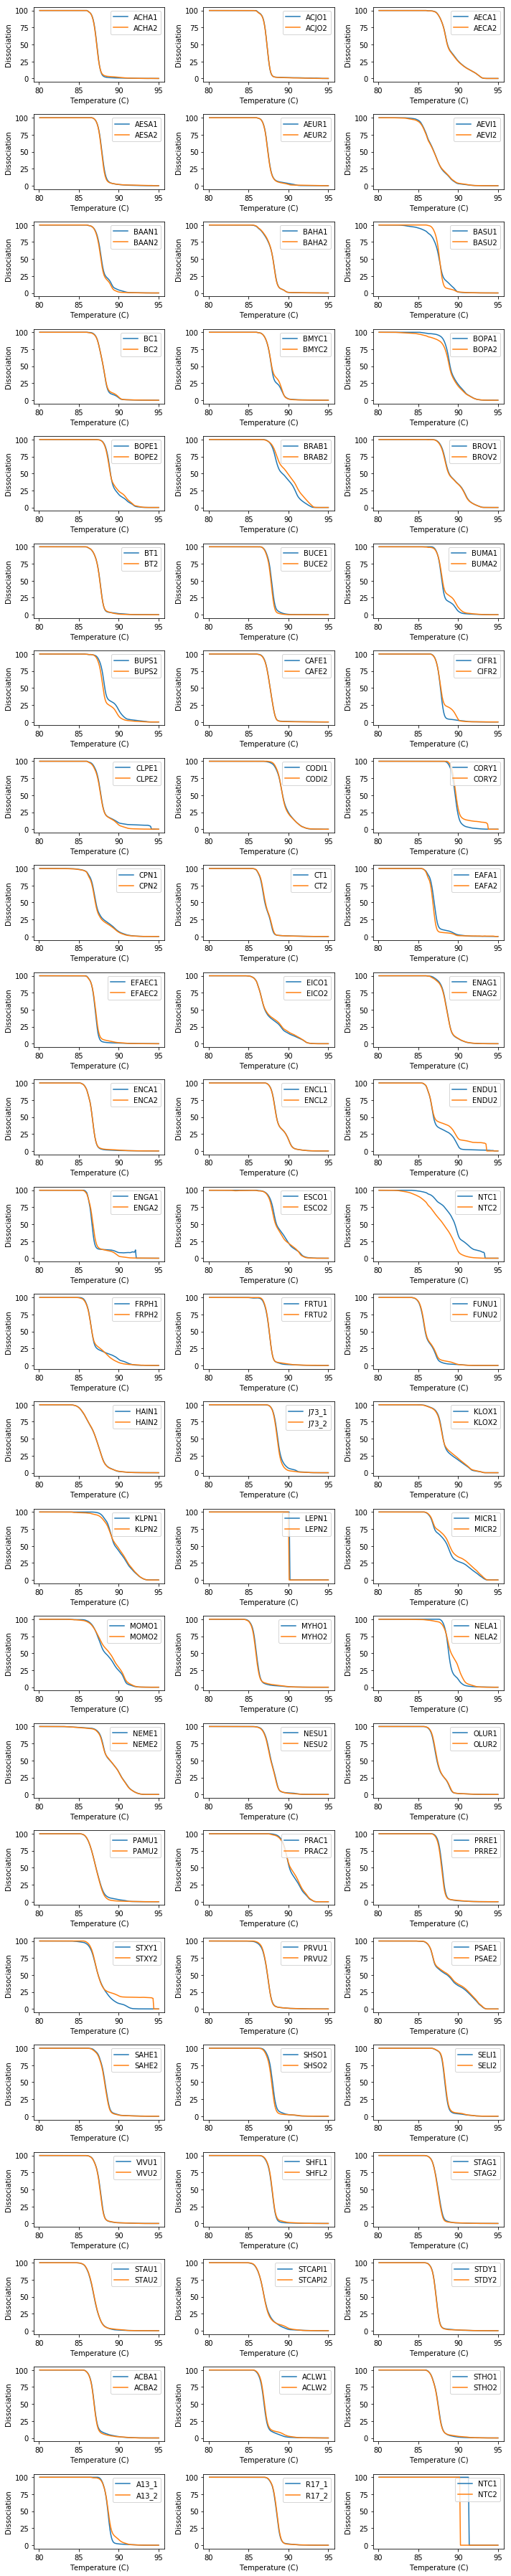

In [5]:
#Clip out the temps we dont want.
temps = [x for x in df.columns[1:] if float(x)>80]
df_chk = df[[df.columns[0]] + temps]
temps = [float(x) for x in temps]

plt.rcParams['figure.figsize'] = [10, 50]
ind = 0
#Cycle through the rows by index
for i in range(0, len(df_chk), 2):
    #get the curve and tag data
    crv1 = cm.norm_curve(df_chk.iloc[i].values[1:], temps, 20)
    crv2 = cm.norm_curve(df_chk.iloc[i + 1].values[1:], temps, 20)
    tag1 = df_chk.iloc[i].values[0]
    tag2 = df_chk.iloc[i + 1].values[0]
    
    #plot out the data
    ind +=1
    plt.subplot((len(df)/2)/3,3,ind)
    plt.plot(temps, crv1, label=tag1)
    plt.plot(temps, crv2, label=tag2)
    plt.legend(loc="upper right")
    plt.xlabel('Temperature (C)')
    plt.ylabel('Dissociation')
plt.tight_layout()
plt.show()    


Finally, I want to port in one good rep into the database with a normalized and raw version. The data is linked back to the original sequence. 

In [6]:
bad = ['BASU', 'BOPA','CIFR', 'CLPE', 'CORY','ENDU', 'ENGA','LEPN','STXY', 'NELA', 'NTC']
#Create the table
sql_command = """
DROP TABLE IF EXISTS curves;
CREATE TABLE curves (
    id INTEGER PRIMARY KEY,
    perfomed_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    seq_id INTEGER,
    raw_curve array,
    norm_curve array,    
    FOREIGN KEY (seq_id) REFERENCES sequences(id));
"""
cur.executescript(sql_command)
conn.commit()
cnt = 0
#Cycle through the rows by index
for i in range(0, len(df_chk), 2):
    tag = df.iloc[i].values[0][:-1]    
    if tag not in bad:
        #get the curve and tag data
        raw_crv = np.array(df.iloc[i].values[1:])
        nrm_crv = np.array(cm.norm_curve(df_chk.iloc[i].values[1:], temps, 20))

        #Get the sequence ID
        sql_command="""
        SELECT * FROM raw_sequences WHERE org_id="%s" AND primer_id_f="%s" AND primer_id_r="%s";
        """ % (tag, 'V3_F', 'V3_R')
        cur.execute(sql_command)
        
        data = cur.fetchone()
        if data is not None:
            cur.execute('INSERT INTO curves (seq_id, raw_curve, norm_curve) VALUES (?, ?, ?)',
                    (data[0], raw_crv, nrm_crv))
            conn.commit()
            cnt += 1 

# Add in UMelt Data

# Conclusion

Now I should have the data cleaned and in a single file format to work with. The database is extensible for future projects if needed. 